In [1]:
import pandas as pd
from sklearn import preprocessing
import xgboost as xg
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz 
import warnings
import numpy as np
import sqlite3
import json
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline


warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('predictor_pol/encuestas.csv')

In [3]:
cand_data = json.loads(open('predictor_pol/candidatos.json','r').read())

In [4]:
def get_party(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return p['party']
    return 'n/a'

def get_name(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return c['name']
    return 'n/a'

In [5]:
df

,id,candidato,fecha
0,30,16,2019-02-03T16:13:13.649130
1,31,9,2019-02-04T22:14:04.368663
2,32,4,2019-02-05T13:03:33.624680
3,33,19,2019-02-05T16:06:41.040221
4,34,18,2019-02-05T16:39:54.482634
5,35,20,2019-02-06T16:33:27.625946
6,36,17,2019-02-06T16:47:40.714679
7,37,4,2019-02-06T16:51:44.308477
8,38,3,2019-02-06T16:52:06.318997
9,39,3,2019-02-06T17:00:09.220160


In [6]:
df['partido'] = df.candidato.apply(get_party)
df['nombre'] = df.candidato.apply(get_name)

In [7]:
print("cantidad de registros: {}".format(len(df)))

cantidad de registros: 141


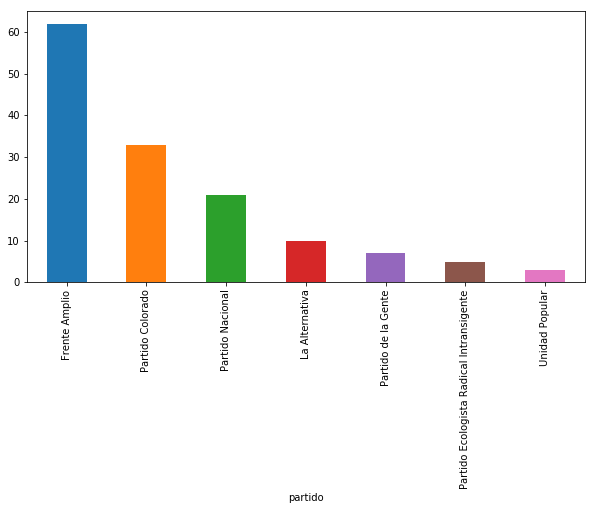

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]
df.groupby('partido').size().sort_values(ascending=False).plot.bar()

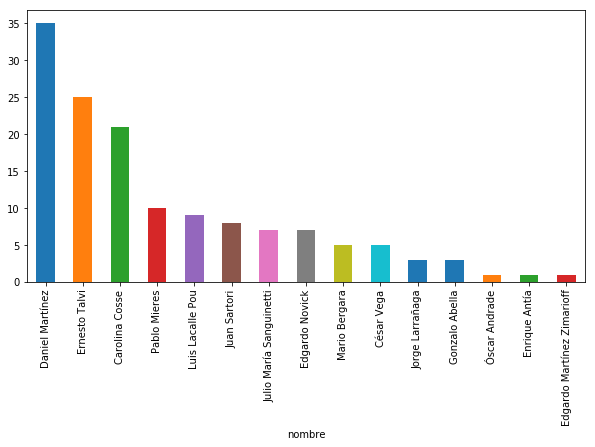

In [9]:
df.groupby('nombre').size().sort_values(ascending=False).plot.bar()

In [10]:
df.head()

,id,candidato,fecha,partido,nombre
0,30,16,2019-02-03T16:13:13.649130,Partido Colorado,Julio María Sanguinetti
1,31,9,2019-02-04T22:14:04.368663,Partido Nacional,Luis Lacalle Pou
2,32,4,2019-02-05T13:03:33.624680,Frente Amplio,Daniel Martínez
3,33,19,2019-02-05T16:06:41.040221,Unidad Popular,Gonzalo Abella
4,34,18,2019-02-05T16:39:54.482634,La Alternativa,Pablo Mieres


In [11]:
respuestas = pd.read_csv('predictor_pol/respuestas_encuestas.csv')

In [12]:
def resp(id_encuesta,id_pregunta):
    s= respuestas[(respuestas['id_encuesta'] == id_encuesta) & (respuestas['id_pregunta'] == id_pregunta)]['respuesta']
    return s.get_values()[0]

In [13]:
for i in range(1,27):
    df['resp_{}'.format(i)] = df.id.apply(lambda x: resp(x,i))

In [14]:
df.head()

,id,candidato,fecha,partido,nombre,resp_1,resp_2,resp_3,resp_4,resp_5,...,resp_17,resp_18,resp_19,resp_20,resp_21,resp_22,resp_23,resp_24,resp_25,resp_26
0,30,16,2019-02-03T16:13:13.649130,Partido Colorado,Julio María Sanguinetti,4,5,4,2,2,...,2,3,5,4,3,3,5,4,4,4
1,31,9,2019-02-04T22:14:04.368663,Partido Nacional,Luis Lacalle Pou,4,4,1,2,3,...,3,1,2,5,5,5,5,4,3,5
2,32,4,2019-02-05T13:03:33.624680,Frente Amplio,Daniel Martínez,3,4,3,4,4,...,2,3,2,1,3,2,5,1,1,4
3,33,19,2019-02-05T16:06:41.040221,Unidad Popular,Gonzalo Abella,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,34,18,2019-02-05T16:39:54.482634,La Alternativa,Pablo Mieres,4,4,3,2,5,...,2,3,1,1,2,4,4,2,1,4


In [15]:
features = []
for i in range(1,27):
    features.append('resp_{}'.format(i))
df_train, df_test = train_test_split(df, test_size=0.20)
modelo_candidato = xg.XGBClassifier().fit(df_train[features], df_train.candidato)
df_test['candidato_predicho'] = modelo_candidato.predict(df_test[features])

ok = len(df_test[df_test.candidato_predicho == df_test.candidato])
precision = ok/len(df_test)
print("precision: {}".format(precision))

precision: 0.2413793103448276


### 27% no es una buena precision

In [16]:
df_test['nombre_predicho'] = df_test.candidato_predicho.apply(get_name)
df_test['partido_predicho'] = df_test.candidato_predicho.apply(get_party)
df_test[['candidato','candidato_predicho','nombre','partido','nombre_predicho','partido_predicho']].head()


,candidato,candidato_predicho,nombre,partido,nombre_predicho,partido_predicho
96,4,3,Daniel Martínez,Frente Amplio,Carolina Cosse,Frente Amplio
19,17,10,Ernesto Talvi,Partido Colorado,Jorge Larrañaga,Partido Nacional
33,4,3,Daniel Martínez,Frente Amplio,Carolina Cosse,Frente Amplio
122,11,17,Juan Sartori,Partido Nacional,Ernesto Talvi,Partido Colorado
43,21,18,César Vega,Partido Ecologista Radical Intransigente,Pablo Mieres,La Alternativa


In [17]:
ok = len(df_test[df_test.partido_predicho == df_test.partido])
precision = ok/len(df_test)
print("precision: {}".format(precision))

precision: 0.4827586206896552


### con el partido tampoco se ve muy bien el panorama

# Ahora probamos KNeighborsClassifier

In [18]:
k=12
n=12
pca = PCA(n_components=n)
pca.fit(df[features])
X = pca.transform(df[features])
y = df.candidato
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
candidate_model = KNeighborsClassifier(n_neighbors=12)
candidate_model.fit(X_train, y_train)
df_test['kn_candidate_prediction'] = candidate_model.predict(pca.transform(df_test[features]))

ok = len(df_test[df_test.kn_candidate_prediction == df_test.candidato])
precision = ok/len(df_test)
print("precision candidato: {}".format(precision))

precision candidato: 0.4482758620689655


Mucho mejor!

In [19]:
import joblib
from joblib import dump, load
pcax = joblib.load('predictor_pol/pca.joblib')

d={'resp_21': ['1'], 'resp_1': ['1'], 
   'resp_23': ['1'], 'resp_24': ['1'], 'resp_11': ['1'], 
   'resp_9': ['1'], 'resp_13': ['1'], 'resp_14': ['1'], 
   'resp_10': ['1'], 'resp_22': ['1'], 'resp_5': ['1'], 'resp_16': ['1'], 
   'resp_3': ['1'], 'resp_18': ['1'], 'resp_2': ['1'], 'resp_8': ['1'], 
   'resp_12': ['1'], 'resp_19': ['1'], 'resp_17': ['1'], 'resp_26': ['1'], 
   'resp_20': ['1'], 'resp_4': ['1'], 'resp_25': ['1'], 'resp_15': ['1'], 'resp_6': ['1'], 'resp_7': ['1']}
foo = pd.DataFrame.from_dict(d)

In [20]:
bar = pcax.transform(foo)

In [21]:
bar#-5.5,4.68

array([[-5.56610644,  4.68282465,  1.84186324,  3.8931881 , -6.01172645,
         0.63634402,  1.43362929, -0.29722699, -2.26452325,  0.21964191,
        -1.02451488, -0.26998255]])

In [22]:
candidate_model.predict(bar)#3


array([4])